In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)


<h1>Read in the data and see the first few rows</h1>

In [187]:
df = pd.read_csv('data/dylan_data/play_by_play_2010_11.csv', encoding='latin1')
df.head(5)

,xg,event_id,event_type,event,secondary_type,event_team,event_team_type,description,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,event_player_3_name,event_player_3_type,event_goalie_name,strength_state,strength_code,strength,game_winning_goal,empty_net,penalty_severity,penalty_minutes,event_idx,num_on,players_on,num_off,players_off,extra_attacker,x,y,x_fixed,y_fixed,shot_distance,shot_angle,home_skaters,away_skaters,home_on_1,home_on_2,home_on_3,home_on_4,home_on_5,home_on_6,home_on_7,away_on_1,away_on_2,away_on_3,away_on_4,away_on_5,away_on_6,away_on_7,home_goalie,away_goalie,game_id,event_player_1_id,event_player_1_link,event_player_1_season_total,event_player_2_id,event_player_2_link,event_player_2_season_total,event_player_3_id,event_player_3_link,event_player_3_season_total,event_player_4_id,event_player_4_name,event_player_4_link,event_player_4_type,period_type,ordinal_num,period_time,period_time_remaining,date_time,event_team_id,event_team_link,event_team_abbr,home_final,away_final,event_goalie_id,event_goalie_link,event_goalie_type,season,season_type,game_date,game_start,game_end,game_length,game_state,detailed_state,venue_name,venue_link,home_name,home_abbreviation,home_division_name,home_conference_name,home_id,away_name,away_abbreviation,away_division_name,away_conference_name,away_id,venue_id
0,NaN,2.010020e+13,GAME_SCHEDULED,Game Scheduled,NaN,NaN,NaN,Game Scheduled,1,0,1200,0,3600,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0v0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010020001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REGULAR,1st,00:00,20:00,2010-10-07T22:16:55Z,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,20102011,R,2010-10-07,2010-10-07 19:00:00,2010-10-07 21:42:28,2H 42M 28S,Final,Final,Air Canada Centre,/api/v1/venues/5015,Toronto Maple Leafs,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
1,NaN,2.010020e+13,CHANGE,Change,NaN,Montréal Canadiens,away,"ON: Hal Gill, Scott Gomez, Brian Gionta, Josh ...",1,0,1200,0,3600,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5v0,NaN,NaN,NaN,NaN,NaN,NaN,1,6.0,"Hal Gill, Scott Gomez, Brian Gionta, Josh Gorg...",NaN,None,False,NaN,NaN,NaN,NaN,NaN,NaN,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott.Gomez,Benoit.Pouliot,Josh.Gorges,Hal.Gill,Brian.Gionta,NaN,NaN,NaN,Carey.Price,2010020001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REGULAR,1st,00:00,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,20102011,R,2010-10-07,2010-10-07 19:00:00,2010-10-07 21:42:28,2H 42M 28S,Final,Final,Air Canada Centre,/api/v1/venues/5015,Toronto Maple Leafs,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
2,NaN,2.010020e+13,CHANGE,Change,Line change,Toronto Maple Leafs,home,"ON: Jean-Sebastien Giguere, Francois Beauchemi...",1,0,1200,0,3600,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5v5,NaN,NaN,NaN,NaN,NaN,NaN,2,6.0,"Jean-Sebastien Giguere, Francois Beauchemin, F...",NaN,None,False,NaN,NaN,NaN,NaN,NaN,NaN,5,5,Dion.Phaneuf,Fredrik.Sjostrom,Francois.Beauchemin,Colby.Armstrong,Tim.Brent,NaN,NaN,Scott.Gomez,Benoit.Pouliot,Josh.Gorges,Hal.Gill,Brian.Gionta,NaN,NaN,Jean.Sebastien.Giguere,Carey.Price,2010020001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REGULAR,1st,00:00,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,20102011,R,2010-10-07,2010-10-07 19:00:00,2010-10-07 21:42:28,2H 42M 28S,Final,Final,Air Canada Centre,/api/v1/venues/5015,Toronto Maple Leafs,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
3,NaN,2.010020e+13,FACEOFF,Faceoff,NaN,Montréal Canadiens,away,Scott Gomez faceoff won against Tim Brent,1,0,1200,0,3600,0,0,Scott.Gomez,Winner,Tim.Brent,Loser,NaN,NaN,NaN,5v5,EV,Even,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,False,0.0,0.0,0.0,0.0,NaN,NaN,5,5,Dion.Phaneuf,Fredrik.Sjostrom,Francois.Beauchemin,Colby.Armstrong,Tim.Brent,NaN,NaN,Scot

In [91]:
# Group by game_id, and count the number of each event time.
# Then, unstack the result to make the event types into columns.
shot_stuff = df.groupby(['game_id', 'event_team', 'event_type']).size().unstack()
shot_stuff

event_type                      BLOCKED_SHOT  CHANGE  FACEOFF  GIVEAWAY  GOAL  \
game_id    event_team                                                           
2010020001 Montréal Canadiens           22.0   185.0     23.0       7.0   2.0   
           Toronto Maple Leafs          21.0   158.0     20.0      16.0   3.0   
2010020002 Philadelphia Flyers          14.0   147.0     22.0       9.0   3.0   
           Pittsburgh Penguins          16.0   144.0     34.0      11.0   2.0   
2010020003 Carolina Hurricanes          19.0   208.0     33.0      11.0   4.0   
...                                      ...     ...      ...       ...   ...   
2010030415 Vancouver Canucks            19.0   222.0     34.0      12.0   1.0   
2010030416 Boston Bruins                14.0   164.0     46.0       NaN   5.0   
           Vancouver Canucks            17.0   173.0     28.0       5.0   2.0   
2010030417 Boston Bruins                14.0   266.0     29.0       8.0   4.0   
           Vancouver Canucks            15.0   193.0     26.0      11.0   NaN   

event_type                       HIT  MISSED_SHOT  PENALTY  SHOT  TAKEAWAY  
game_id    event_team                                                       
2010020001 Montréal Canadiens   34.0         15.0      5.0  26.0       7.0  
           Toronto Maple Leafs  27.0          9.0      3.0  21.0       6.0  
2010020002 Philadelphia Flyers  34.0         10.0      6.0  24.0       1.0  
           Pittsburgh Penguins  32.0         18.0      5.0  29.0       9.0  
2010020003 Carolina Hurricanes  14.0          9.0      5.0  27.0       3.0  
...                              ...          ...      ...   ...       ...  
2010030415 Vancouver Canucks    47.0         12.0      5.0  24.0      15.0  
2010030416 Boston Bruins        43.0          5.0     10.0  35.0       5.0  
           Vancouver Canucks    38.0         15.0      9.0  36.0       5.0  
2010030417 Boston Bruins        29.0          8.0      2.0  17.0       8.0  
           Vancouver Canucks    47.0         10.0      1.0  37.0      12.0  

[2580 rows x 10 columns]

In [188]:
def get_data(df, game_id):
    """
    Extracts and organizes event data for a specific game.

    Args:
    df (DataFrame): The DataFrame containing the game data.
    game_id (int): The ID of the game to retrieve data for.

    Returns:
    tuple: A tuple containing two DataFrames, one for home team events and one for away team events.
    """

    # Filter the DataFrame to get data for the specified game and drop rows with NaN values in event_team_type
    game1 = df[df.game_id == game_id] 
    game1 = game1.dropna(subset=['event_team_type'])

    # Get unique event types (excluding CHANGE)
    event_types = game1.event_type.unique()
    event_types = np.delete(event_types, np.where(event_types == 'CHANGE'))
    event_types = np.append(event_types, ['TIME_REMAINING', 'HOME', 'WIN', 'TEAM', 'GAME_ID', 'CORSI', 'FENWICK'])

    # Create dictionaries to store event counts for home and away teams
    final_dict = {f'HOME_{event}': 0 for event in event_types}
    away_dict = {f'AWAY_{event}': 0 for event in event_types}
    final_dict.update(away_dict)

    # Create DataFrames to store event data for home and away teams
    final_df = False

    # Iterate through the events in the game and count them
    for _, row in game1.iterrows():
        # Skip events with NaN event_team_type or events of type CHANGE
        if pd.isnull(row['event_team_type']) or row['event_type'] == 'CHANGE':
            continue
        
        # Determine if the event belongs to the home or away team and update counts accordingly
        if row['event_team_type'] == 'home':
            final_dict[f"HOME_{row['event_type']}"] += 1
            final_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            final_dict['HOME_HOME'] = 1
            final_dict['WIN'] = 1 if row['home_final'] > row['away_final'] else 0
            final_dict['HOME_TEAM'] = row['team_encoded']
            final_dict['GAME_ID'] = game_id

            # Get the Corsi and Fenwick for the home team
            if row['strength_code'] == "EV":
                final_dict['HOME_CORSI'] = calculate_corsi(final_dict, 'HOME')
                final_dict['HOME_FENWICK'] = calculate_fenwick(final_dict, 'HOME')
                final_dict['HOME_CORSI_FOR'] = calculate_corsi_for(final_dict['HOME_CORSI'], final_dict['AWAY_CORSI'])
                final_dict['HOME_FENWICK_FOR'] = calculate_fenwick_for(final_dict['HOME_FENWICK'], final_dict['AWAY_FENWICK'])
            
        else:
            final_dict[f"AWAY_{row['event_type']}"] += 1
            final_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            final_dict['AWAY_HOME'] = 0
            final_dict['WIN'] = 0 if row['home_final'] < row['away_final'] else 1
            final_dict['AWAY_TEAM'] = row['team_encoded']
            final_dict['GAME_ID'] = game_id
            
            # Get the Corsi and Fenwick for the away team
            if row['strength_code'] == "EV":
                final_dict['AWAY_CORSI'] = calculate_corsi(final_dict, "AWAY")
                final_dict['AWAY_FENWICK'] = calculate_fenwick(final_dict, "AWAY")
                final_dict['AWAY_CORSI_FOR'] = calculate_corsi_for(final_dict['AWAY_CORSI'], final_dict['HOME_CORSI'])
                final_dict['AWAY_FENWICK_FOR'] = calculate_fenwick_for(final_dict['AWAY_FENWICK'], final_dict['HOME_FENWICK'])
                
        if type(final_df) is bool:
            final_df = pd.DataFrame(final_dict, index=[0])
        else:
            final_df = final_df.append(final_dict, ignore_index=True)
        
    return final_df


def get_data_opt(df, game_id):
    """
    Extracts and organizes event data for a specific game.

    Args:
    df (DataFrame): The DataFrame containing the game data.
    game_id (int): The ID of the game to retrieve data for.

    Returns:
    tuple: A tuple containing two DataFrames, one for home team events and one for away team events.
    """

    # Filter the DataFrame to get data for the specified game and drop rows with NaN values in event_team_type
    game1 = df[df.game_id == game_id] 
    game1 = game1.dropna(subset=['event_team_type'])


    # Get unique event types (excluding CHANGE)
    event_types = game1.event_type.unique()
    event_types = np.delete(event_types, np.where(event_types == 'CHANGE'))
    event_types = np.append(event_types, ['TIME_REMAINING', 'HOME', 'WIN', 'TEAM', 'GAME_ID', 'CORSI', 'FENWICK'])

    # Create dictionaries to store event counts for home and away teams
    final_dict = {f'HOME_{event}': 0 for event in event_types}
    away_dict = {f'AWAY_{event}': 0 for event in event_types}
    final_dict.update(away_dict)

    # Create DataFrames to store event data for home and away teams
    final_df = False
    
    # Keep only the columns we need
    game1 = game1[['event_team_type', 'event_type', 'game_seconds_remaining', 'home_final', 'away_final', 'team_encoded', 'strength_code']]
    
    # Drop all 'CHANGE' events from event_type
    game1 = game1[game1.event_type != 'CHANGE']

    # Iterate through the events in the game and count them
    for team, event, sec_rem, home_score, away_score, team_num, strength  in game1.values:
        # Skip events with NaN event_team_type or events of type CHANGE
        if pd.isnull(team) or event == 'CHANGE':
            continue
        
        # Determine if the event belongs to the home or away team and update counts accordingly
        if team == 'home':
            final_dict[f"HOME_{event}"] += 1
            final_dict['TIME_REMAINING'] = sec_rem
            final_dict['HOME_HOME'] = 1
            final_dict['WIN'] = 1 if home_score > away_score else 0
            final_dict['HOME_TEAM'] = team_num
            final_dict['GAME_ID'] = game_id

            # Get the Corsi and Fenwick for the home team
            if strength == "EV":
                final_dict['HOME_CORSI'] = calculate_corsi(final_dict, 'HOME')
                final_dict['HOME_FENWICK'] = calculate_fenwick(final_dict, 'HOME')
                final_dict['HOME_CORSI_FOR'] = calculate_corsi_for(final_dict['HOME_CORSI'], final_dict['AWAY_CORSI'])
                final_dict['HOME_FENWICK_FOR'] = calculate_fenwick_for(final_dict['HOME_FENWICK'], final_dict['AWAY_FENWICK'])
            
        else:
            final_dict[f"AWAY_{event}"] += 1
            final_dict['TIME_REMAINING'] = sec_rem
            final_dict['AWAY_HOME'] = 0
            final_dict['WIN'] = 0 if home_score < away_score else 1
            final_dict['AWAY_TEAM'] = team_num
            final_dict['GAME_ID'] = game_id
            
            # Get the Corsi and Fenwick for the away team
            if strength == "EV":
                final_dict['AWAY_CORSI'] = calculate_corsi(final_dict, "AWAY")
                final_dict['AWAY_FENWICK'] = calculate_fenwick(final_dict, "AWAY")
                final_dict['AWAY_CORSI_FOR'] = calculate_corsi_for(final_dict['AWAY_CORSI'], final_dict['HOME_CORSI'])
                final_dict['AWAY_FENWICK_FOR'] = calculate_fenwick_for(final_dict['AWAY_FENWICK'], final_dict['HOME_FENWICK'])
                
        if type(final_df) is bool:
            final_df = pd.DataFrame(final_dict, index=[0])
        else:
            final_df = final_df.append(final_dict, ignore_index=True)
        
    return final_df


def get_label_encoder(teams):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(teams)
    return le


def calculate_corsi(team_dict, h_or_a):
    """
    Calculates the Corsi for a team.

    Args:
    team_dict (dict): A dictionary containing event counts for a team.

    Returns:
    int: The Corsi for the team.
    """
    return team_dict[f'{h_or_a}_SHOT'] + team_dict[f'{h_or_a}_MISSED_SHOT'] + team_dict[f'{h_or_a}_BLOCKED_SHOT']


def calculate_fenwick(team_dict, h_or_a):
    """
    Calculates the Fenwick for a team.

    Args:
    team_dict (dict): A dictionary containing event counts for a team.

    Returns:
    int: The Fenwick for the team.
    """
    return team_dict[f'{h_or_a}_SHOT'] + team_dict[f'{h_or_a}_MISSED_SHOT']


def calculate_corsi_for(team_corsi, opp_corsi):
    """
    Calculates the Corsi For Percentage for a team.

    Args:
    team_corsi (int): The Corsi for the team.
    opp_corsi (int): The Corsi for the opposing team.

    Returns:
    float: The Corsi For Percentage for the team.
    """
    # Check if the denominator is zero to avoid division by zero
    if team_corsi + opp_corsi == 0:
        return 0
    
    return team_corsi / (team_corsi + opp_corsi)


def calculate_fenwick_for(team_fenwick, opp_fenwick):
    """
    Calculates the Fenwick For Percentage for a team.

    Args:
    team_fenwick (int): The Fenwick for the team.
    opp_fenwick (int): The Fenwick for the opposing team.

    Returns:
    float: The Fenwick For Percentage for the team.
    """
    # Check if the denominator is zero to avoid division by zero
    if team_fenwick + opp_fenwick == 0:
        return 0
    
    return team_fenwick / (team_fenwick + opp_fenwick)

def merge_home_away(home_df, away_df):
     # change the names in the home_df to be HOME_[current column name] and same for away_df
     home_df.columns = ['HOME_' + col for col in home_df.columns]
     away_df.columns = ['AWAY_' + col for col in away_df.columns]
     # change TIME_REMAINING, WIN, GAME_ID to be the same in both dataframes
     home_df = home_df.rename(columns={'HOME_TIME_REMAINING': 'TIME_REMAINING', 'HOME_WIN': 'WIN', 'HOME_GAME_ID': 'GAME_ID'})
     away_df = away_df.rename(columns={'AWAY_TIME_REMAINING': 'TIME_REMAINING', 'AWAY_WIN': 'WIN', 'AWAY_GAME_ID': 'GAME_ID'})

     full = pd.merge(home_df, away_df, on=['TIME_REMAINING', 'WIN', 'GAME_ID'], how='outer')

     # if home_df has 1 in WIN column than make all the values in the WIN column 1
     if 1 in home_df.WIN.unique():
          full.WIN = 1
     elif 1 in away_df.WIN.unique():
          full.WIN = 0

     full.drop(columns=['HOME_HOME', 'AWAY_HOME'])
     full = full.sort_values(by='TIME_REMAINING')
     full.fillna(method='ffill', inplace=True)
     full.fillna(0, inplace=True)

     return full

In [189]:
# Copy the dataframe
df_copy = df.copy()

# Drop NaN's from event_team_type
df_copy = df_copy.dropna(subset=['event_team'])

# Get all of the data
unique_game_ids = df.game_id.unique()

# Get the label encoder for the teams
team_names = np.sort(df_copy.event_team.dropna().unique())
label_encoder = get_label_encoder(team_names)

# Label encode the teams
df_copy['team_encoded'] = label_encoder.transform(df_copy.event_team)

# Iterate through the games
game_bar = tqdm(total=len(unique_game_ids))
final_df_opt = pd.DataFrame()
for game_id in unique_game_ids:
    final_df_p = get_data_opt(df_copy, game_id)
    final_df_opt = final_df_opt.append(final_df_p)
    game_bar.update(1)

final_df_opt

  0%|          | 0/1290 [00:00<?, ?it/s]

,HOME_FACEOFF,HOME_HIT,HOME_GIVEAWAY,HOME_BLOCKED_SHOT,HOME_SHOT,HOME_MISSED_SHOT,HOME_GOAL,HOME_TAKEAWAY,HOME_PENALTY,HOME_TIME_REMAINING,HOME_HOME,HOME_WIN,HOME_TEAM,HOME_GAME_ID,HOME_CORSI,HOME_FENWICK,AWAY_FACEOFF,AWAY_HIT,AWAY_GIVEAWAY,AWAY_BLOCKED_SHOT,AWAY_SHOT,AWAY_MISSED_SHOT,AWAY_GOAL,AWAY_TAKEAWAY,AWAY_PENALTY,AWAY_TIME_REMAINING,AWAY_HOME,AWAY_WIN,AWAY_TEAM,AWAY_GAME_ID,AWAY_CORSI,AWAY_FENWICK,TIME_REMAINING,WIN,GAME_ID,AWAY_CORSI_FOR,AWAY_FENWICK_FOR,HOME_CORSI_FOR,HOME_FENWICK_FOR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,3600.0,1.0,2.010020e+09,0.000000,0.000000,NaN,NaN
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,3585.0,1.0,2.010020e+09,0.000000,0.000000,0.000000,0.000000
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,3554.0,1.0,2.010020e+09,0.000000,0.000000,0.000000,0.000000
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,3543.0,1.0,2.010020e+09,0.000000,0.000000,0.000000,0.000000
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,3531.0,1.0,2.010020e+09,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,25.0,47.0,11.0,15.0,37.0,9.0,0.0,11.0,1.0,0.0,1.0,0.0,28.0,0.0,61.0,46.0,29.0,29.0,8.0,13.0,17.0,8.0,4.0,8.0,2.0,0.0,0.0,0.0,2.0,0.0,38.0,25.0,71.0,0.0,2.010030e+09,0.383838,0.352113,0.622449,0.657143
274,25.0,47.0,11.0,15.0,37.0,9.0,0.0,11.0,1.0,0.0,1.0,0.0,28.0,0.0,61.0,46.0,29.0,29.0,8.0,14.0,17.0,8.0,4.0,8.0,2.0,0.0,0.0,0.0,2.0,0.0,39.0,25.0,60.0,0.0,2.010030e+09,0.390000,0.352113,0.622449,0.657143
275,25.0,47.0,11.0,15.0,37.0,9.0,0.0,12.0,1.0,0.0,1.0,0.0,28.0,0.0,61.0,46.0,29.0,29.0,8.0,14.0,17.0,8.0,4.0,8.0,2.0,0.0,0.0,0.0,2.0,0.0,39.0,25.0,48.0,0.0,2.010030e+09,0.390000,0.352113,0.610000,0.647887
276,26.0,47.0,11.0,15.0,37.0,9.0,0.0,12.0,1.0,0.0,1.0,0.0,28.0,0.0,61.0,46.0,29.0,29.0,8.0,14.0,17.0,8.0,4.0,8.0,2.0,0.0,0.0,0.0,2.0,0.0,39.0,25.0,31.0,0.0,2.010030e+09,0.390000,0.352113,0.610000,0.647887


<h1>Basic Initial Data Visualization</h1>

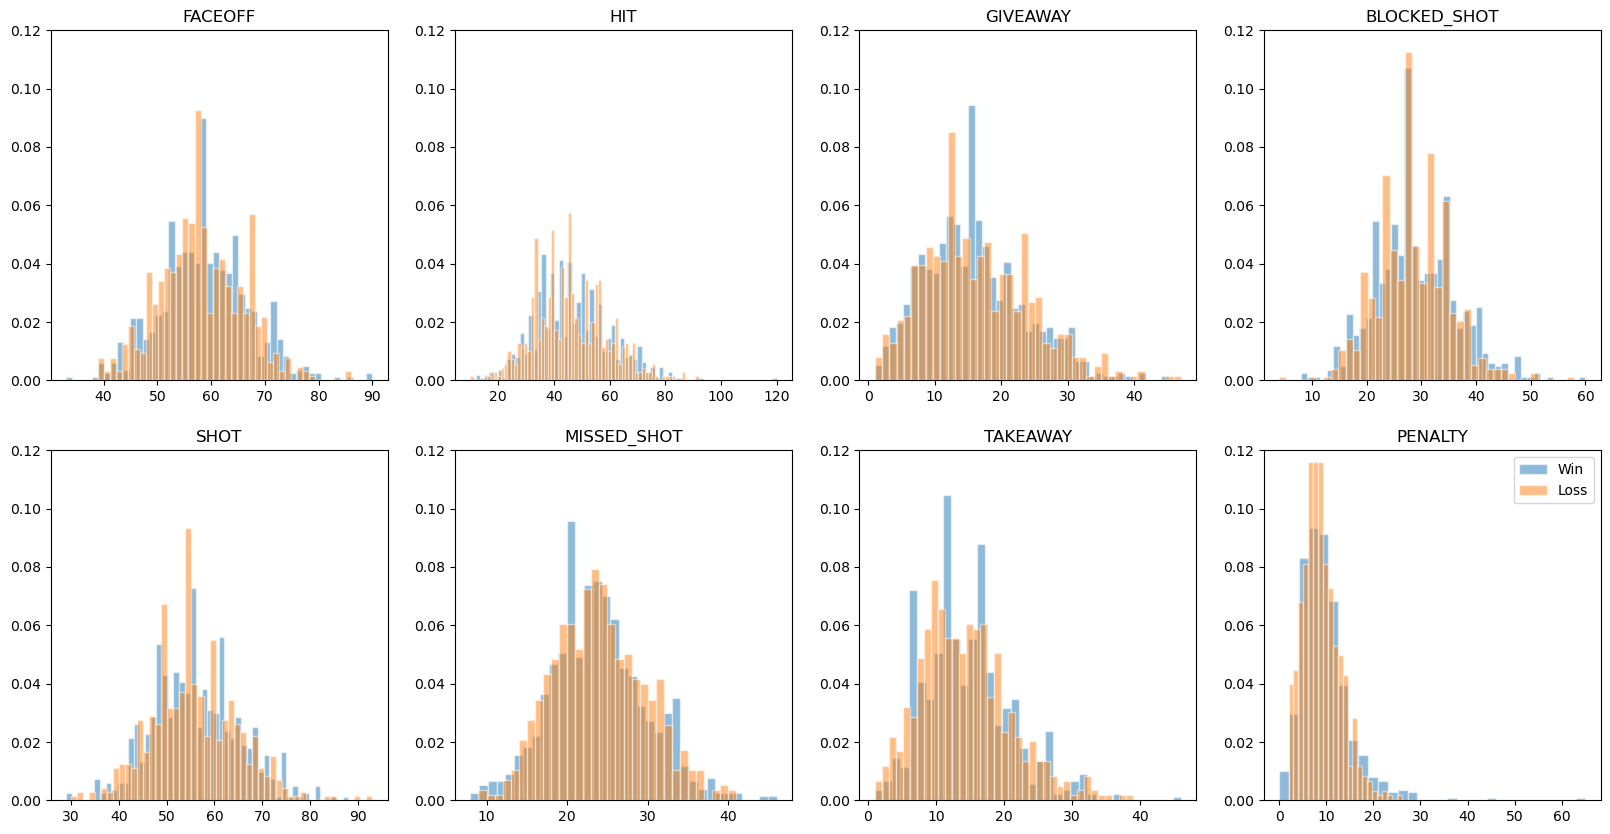

In [190]:
# Get the last rows for each game.
last_row = final_df_opt['GAME_ID'].shift(-1) != final_df_opt['GAME_ID']
last_row = final_df_opt.loc[last_row, :]

# Get rid of NaN's
last_row = last_row.fillna(0)

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
row, co = 2, 4
r, c = 0, 0
for i, col in enumerate(['FACEOFF', 'HIT', 'GIVEAWAY', 'BLOCKED_SHOT', 'SHOT', 'MISSED_SHOT', 'TAKEAWAY', 'PENALTY']):
    mask = last_row['WIN'] == 1
    # These rows plot four histograms per event. Home win, Home loss, Away win, Away loss.
    # ax[r, c].hist(last_row[mask][f'HOME_{col}'], alpha=0.5, bins=len(last_row[mask][f'HOME_{col}'].unique()), label='Home Win', density=True   , edgecolor='white')
    # ax[r, c].hist(last_row[~mask][f'HOME_{col}'], alpha=0.5, bins=len(last_row[~mask][f'HOME_{col}'].unique()), label='Home Loss', density=True, edgecolor='white')
    # ax[r, c].hist(last_row[mask][f'AWAY_{col}'], alpha=0.5, bins=len(last_row[mask][f'AWAY_{col}'].unique()), label='Away Win', density=True   , edgecolor='white')
    # ax[r, c].hist(last_row[~mask][f'AWAY_{col}'], alpha=0.5, bins=len(last_row[~mask][f'AWAY_{col}'].unique()), label='Away Loss', density=True, edgecolor='white')
    # ax[r, c].set_ylim(0, .25)
    # ax[r, c].set_title(col)
    
    # These rows plot two histograms per event. Win and Loss.
    win = last_row[mask][f'HOME_{col}'] + last_row[mask][f'AWAY_{col}']
    loss = last_row[~mask][f'HOME_{col}'] + last_row[~mask][f'AWAY_{col}']
    ax[r, c].hist(win, alpha=0.5, bins=len(win.unique()), label='Win', density=True   , edgecolor='white')
    ax[r, c].hist(loss, alpha=0.5, bins=len(loss.unique()), label='Loss', density=True, edgecolor='white')
    ax[r, c].set_ylim(0, .12)
    ax[r, c].set_title(col)
    
    c += 1
    if c == co:
        c = 0
        r += 1

ax[r-1, c-1].legend()

plt.show()

<h1>Try t-SNE and UMAP on State Vectors</h1>

<h3>Dimension Reduction on Every State Vector in 10 Games</h3>

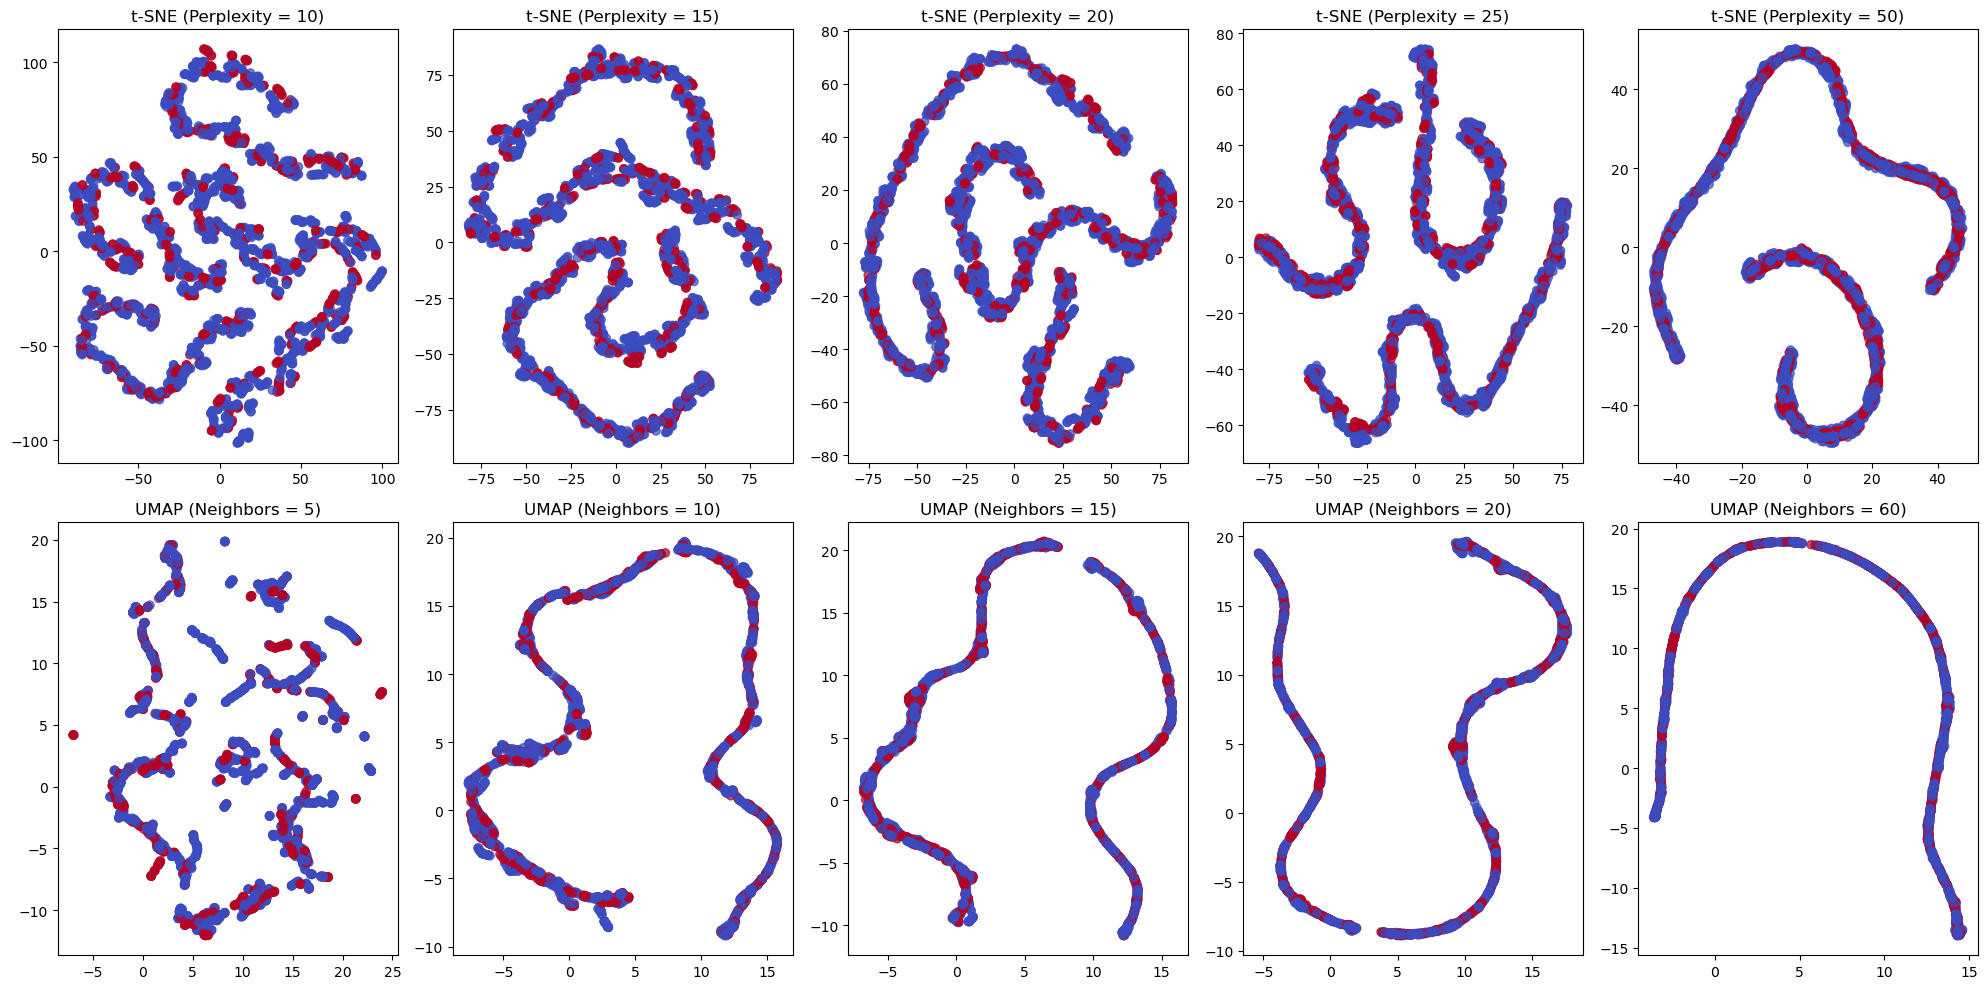

In [138]:
# Get 10 random games to plot.
f_df = final_df_opt.fillna(0).copy()

# Get the game_ids
game_ids = f_df.GAME_ID.unique()
selected = np.random.choice(game_ids, 10)
f_df = f_df[f_df.GAME_ID.isin(selected)]

# Get the data
X = f_df.drop(columns=['WIN', 'GAME_ID'])
y = f_df.WIN

# Plot the results
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i, perp, neigh in zip(range(5), [10, 15, 20, 25, 50], [5, 10, 15, 20, 60]):
    # Initialize the models
    tsne = TSNE(n_components=2, perplexity=perp)
    umap = UMAP(n_components=2, n_neighbors=neigh)

    # Fit the models
    X_tsne = tsne.fit_transform(X)
    X_umap = umap.fit_transform(X)

    ax[0, i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    ax[0, i].set_title(f't-SNE (Perplexity = {perp})')
    ax[1, i].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    ax[1, i].set_title(f'UMAP (Neighbors = {neigh})')

plt.tight_layout()
plt.show()

<h3>Dimension Reduction on Every State Vector for One Game</h3>

[0 1]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


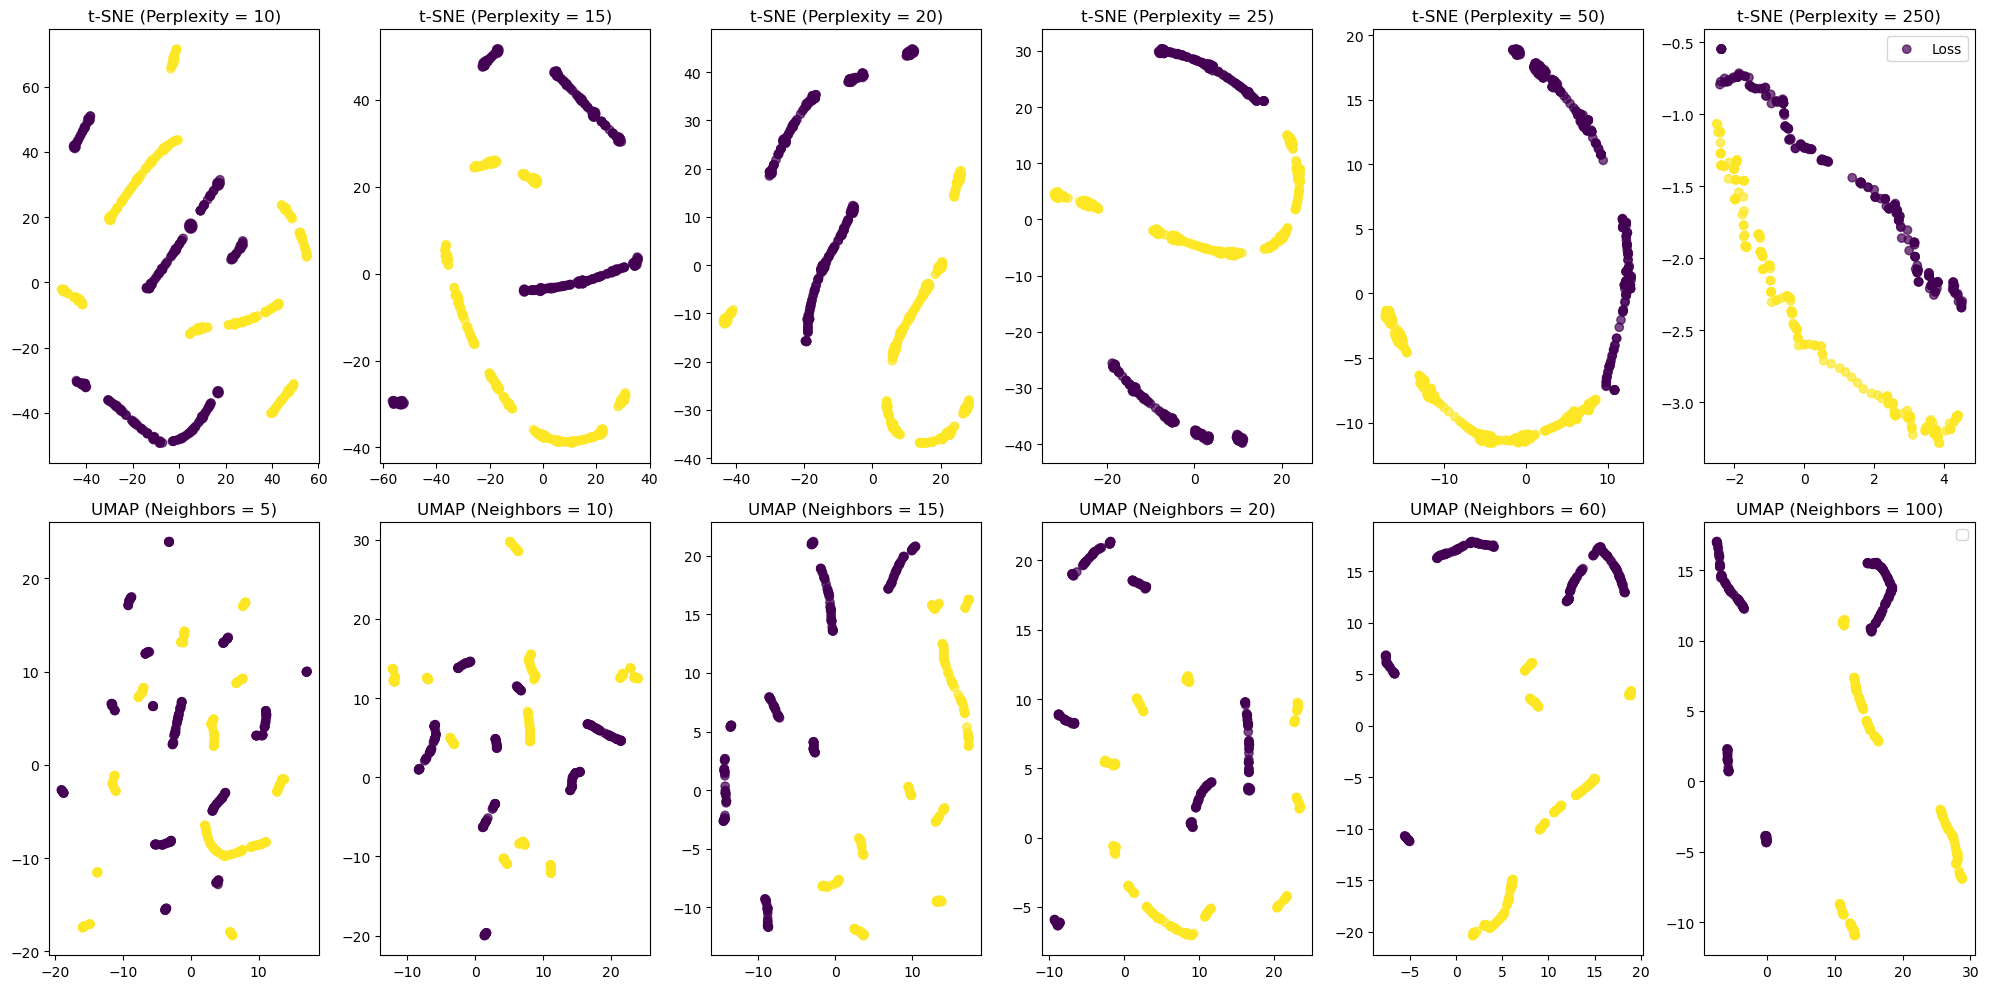

In [36]:
# Split f_df into home and away
test = f_df[f_df['GAME_ID'] == f_df.GAME_ID.unique()[0]]
test_home = test.filter(regex='HOME')
test_away = test.filter(regex='AWAY_')
test_home.columns = test_home.columns.str.replace('HOME_', '')
test_away.columns = test_away.columns.str.replace('AWAY_', '')
test_home['WIN'] = 0
test_away['WIN'] = 1

test = test_home.append(test_away).drop(columns='AWAY_HOME')

# Get the data
X = test.drop(columns=['WIN'])
y = test.WIN
print(y.unique())

# Plot the results
fig, ax = plt.subplots(2, 6, figsize=(20, 10))

for i, perp, neigh in zip(range(6), [10, 15, 20, 25, 50, 250], [5, 10, 15, 20, 60, 100]):
    # Initialize the models
    tsne = TSNE(n_components=2, perplexity=perp)
    umap = UMAP(n_components=2, n_neighbors=neigh)

    # Fit the models
    X_tsne = tsne.fit_transform(X)
    X_umap = umap.fit_transform(X)

    ax[0, i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    ax[0, i].set_title(f't-SNE (Perplexity = {perp})')
    ax[1, i].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', alpha=0.7)
    ax[1, i].set_title(f'UMAP (Neighbors = {neigh})')
    
    # Add legend to the last plot
    if i == 5:
        ax[0, i].legend(['Loss', 'Win'], loc='upper right')
        ax[1, i].legend(['Loss', 'Win'], loc='upper right')

# plt.legend()
plt.tight_layout()
plt.show()

<h1>Compare Our Simulation Against the Real Data</h1>

In [216]:
# Do t-SNE, UMAP, and PCA on the simulated data against the real data
# Simulated data
simulated = pd.read_feather('data/dylan_data/lasts.feather')
actual = last_row.copy()
actual.drop(columns=['TIME_REMAINING', 'WIN', 'GAME_ID', 'AWAY_CORSI_FOR',
       'AWAY_FENWICK_FOR', 'HOME_CORSI_FOR', 'HOME_FENWICK_FOR', 'AWAY_CORSI', 'AWAY_FENWICK',
       'AWAY_GAME_ID', 'AWAY_TIME_REMAINING', 'AWAY_WIN', 'HOME_CORSI',
       'HOME_FENWICK', 'HOME_GAME_ID', 'HOME_HIT', 'AWAY_HIT',
       'HOME_TEAM', 'HOME_TIME_REMAINING', 'HOME_WIN', 'AWAY_HOME','AWAY_TEAM', 'HOME_HOME',
       ], inplace=True)

simulated.drop(columns=['time_remaining', 'home_score', 'away_score', 'game_id', 'BLOCKED_SHOT_-'], inplace=True)
actual = actual[actual.columns.sort_values()]
simulated = simulated[simulated.columns.sort_values()]
simulated.columns = [f'{col[-1]}_{"_".join(col[:-1])}' for col in simulated.columns.str.split('_')]
simulated = simulated[simulated.columns.sort_values()]

# Assign labels
actual['simulated'] = 0
simulated['simulated'] = 1

vals = actual.append(simulated)
X, y = vals.drop(columns=['simulated']), vals.simulated

# Fill all NaN's with 0
X.fillna(0, inplace=True)

# Perform PCA, t-SNE, and UMAP on the data
X_pca = PCA(n_components=2).fit_transform(X)

# fig, ax = plt.subplots(1,3, figsize=(10, 4), dpi=150)
perp = 250
neigh = 150
# Compute t-SNE
X_tsne = TSNE(n_components=2, perplexity=perp).fit_transform(X)

# Compute UMAP
X_umap = UMAP(n_components=2, n_neighbors=neigh).fit_transform(X)

       

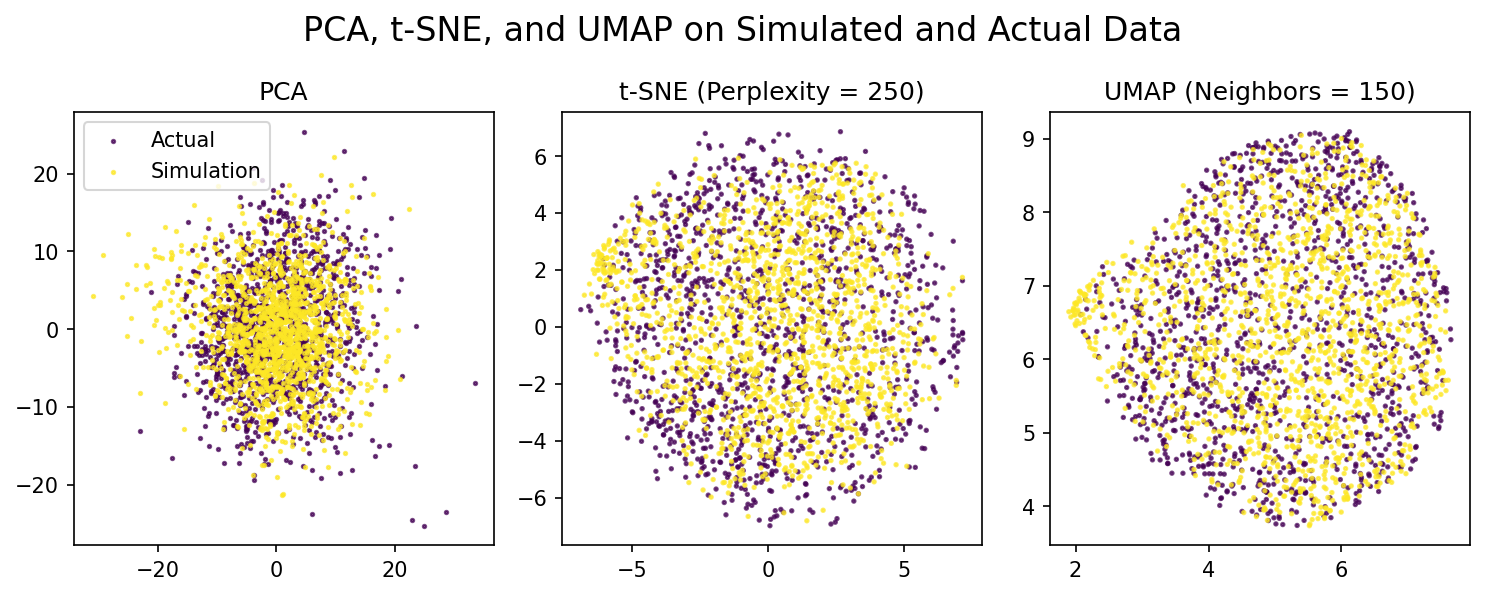

: 

In [217]:
fig, ax = plt.subplots(1,3, figsize=(10, 4), dpi=150)
cmap = 'viridis'
# Plot the results
c = plt.get_cmap(cmap)
ax[0].scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color=c.colors[0], cmap=cmap, alpha=0.7, s=2.5, label='Actual')
ax[0].scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color=c.colors[-1], cmap=cmap, alpha=0.7, s=2.5, label='Simulation')
ax[0].legend(loc='upper left')
ax[0].set_title('PCA')

ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=cmap, alpha=0.7, s=2.5)
ax[1].set_title(f't-SNE (Perplexity = {perp})')

ax[2].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap=cmap, alpha=0.7, s=2.5)
ax[2].set_title(f'UMAP (Neighbors = {neigh})')

plt.suptitle('PCA, t-SNE, and UMAP on Simulated and Actual Data', fontsize=16)
plt.tight_layout()
plt.show()

In [212]:
c.colors[0]

[0.267004, 0.004874, 0.329415]

<h1>Identifying Important Features</h1>

In [170]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Get the data
X = last_row.copy()

# Columns to drop
X = X.drop(columns=['HOME_TIME_REMAINING', 'HOME_HOME', 'HOME_WIN', 'HOME_GAME_ID', 'AWAY_TIME_REMAINING', 'AWAY_HOME', 'AWAY_WIN', 'AWAY_GAME_ID', 'GAME_ID'])

X, y = X.drop(columns=['WIN']), last_row.WIN

# Preprocess your data if necessary
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your Lasso regression model
lasso = Lasso()

# Define a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', lasso)
])

# Define hyperparameters to tune
param_grid = {
    'lasso__alpha': np.linspace(0.001, 10, 100)  # Regularization strength
}

# Perform hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Extract the best model
best_model = grid_search.best_estimator_

# Get the coefficients of the best model
feature_names = X.columns  # Assuming df is your DataFrame
coefficients = best_model.named_steps['lasso'].coef_


# Identify important features
important_features = feature_names[coefficients == 0]
print(f'Important features:   {feature_names[coefficients != 0].str.lower()}')
print(f'Unimportant features: {feature_names[coefficients == 0].str.lower()}')
print(f'Best alpha: {grid_search.best_params_}')

Important features:   Index(['home_faceoff', 'home_hit', 'home_giveaway', 'home_blocked_shot',
       'home_shot', 'home_missed_shot', 'home_goal', 'home_takeaway',
       'home_penalty', 'home_team', 'home_corsi', 'away_faceoff', 'away_hit',
       'away_giveaway', 'away_blocked_shot', 'away_shot', 'away_missed_shot',
       'away_goal', 'away_takeaway', 'away_penalty', 'away_team', 'away_corsi',
       'time_remaining', 'away_corsi_for'],
      dtype='object')
Unimportant features: Index(['home_fenwick', 'away_fenwick', 'away_fenwick_for', 'home_corsi_for',
       'home_fenwick_for'],
      dtype='object')
Best alpha: {'lasso__alpha': 0.001}


<h2>Correlation Matrix</h2>

In [175]:
# Get the data
X = last_row.copy()
X = X.drop(columns=['HOME_TIME_REMAINING', 'HOME_HOME', 'HOME_WIN', 'HOME_GAME_ID', 'AWAY_TIME_REMAINING', 'AWAY_HOME', 'AWAY_WIN', 'AWAY_GAME_ID', 'GAME_ID'])

# Create correlation matrix
X.corr('kendall')['WIN']

HOME_FACEOFF         0.065000
HOME_HIT            -0.050757
HOME_GIVEAWAY       -0.060919
HOME_BLOCKED_SHOT   -0.178852
HOME_SHOT           -0.134340
HOME_MISSED_SHOT    -0.083464
HOME_GOAL            0.550266
HOME_TAKEAWAY        0.081088
HOME_PENALTY         0.021059
HOME_TEAM            0.039545
HOME_CORSI          -0.159695
HOME_FENWICK        -0.119509
AWAY_FACEOFF        -0.014433
AWAY_HIT             0.091131
AWAY_GIVEAWAY        0.040413
AWAY_BLOCKED_SHOT    0.213992
AWAY_SHOT            0.172852
AWAY_MISSED_SHOT     0.118659
AWAY_GOAL           -0.496892
AWAY_TAKEAWAY       -0.091369
AWAY_PENALTY         0.040556
AWAY_TEAM           -0.037516
AWAY_CORSI           0.219378
AWAY_FENWICK         0.166397
TIME_REMAINING      -0.034595
WIN                  1.000000
AWAY_CORSI_FOR       0.237848
AWAY_FENWICK_FOR     0.183412
HOME_CORSI_FOR      -0.238798
HOME_FENWICK_FOR    -0.184740
Name: WIN, dtype: float64

<h1>Various Feature Selection Things</h1>

In [185]:
from sklearn import feature_selection

X = last_row.copy()
X = X.drop(columns=['HOME_TIME_REMAINING', 'HOME_HOME', 'HOME_WIN', 'HOME_GAME_ID', 'AWAY_TIME_REMAINING', 'AWAY_HOME', 'AWAY_WIN', 'AWAY_GAME_ID', 'GAME_ID', 'WIN'])

# Perform feature selection
selector = feature_selection.SelectKBest(score_func=feature_selection.f_classif)
X_new = selector.fit_transform(X, y)

# Get the selected features
selected_features = X.columns[selector.get_support()]
print(f'Selected features from KBest: {selected_features.str.lower().sort_values()}')

# Perform RFE
selector = feature_selection.RFECV(estimator=lasso)
X_new = selector.fit_transform(X, y)

# Get the selected features
selected_features = X.columns[selector.get_support()]
print(f'Selected features from RFE: {selected_features.str.lower().sort_values()}')
print(f'Number of features selected: {len(selected_features)}')
print(selector.cv_results_)

Selected features from KBest: Index(['away_blocked_shot', 'away_corsi', 'away_corsi_for', 'away_fenwick_for',
       'away_goal', 'away_shot', 'home_blocked_shot', 'home_corsi_for',
       'home_fenwick_for', 'home_goal'],
      dtype='object')
Selected features from RFE: Index(['away_corsi', 'home_corsi'], dtype='object')
Number of features selected: 2
{'mean_test_score': array([0.02454323, 0.02605277, 0.02605277, 0.02605277, 0.02605277,
       0.02605277, 0.02605277, 0.02605277, 0.02605277, 0.02605277,
       0.02605277, 0.02605277, 0.02605277, 0.02605277, 0.02605277,
       0.02605277, 0.02605277, 0.02605277, 0.02605277, 0.02605277,
       0.02605277, 0.02605277, 0.02605277, 0.02605277, 0.02605277,
       0.02605277, 0.02605277, 0.02605277, 0.02605277]), 'std_test_score': array([0.00406358, 0.00400013, 0.00400013, 0.00400013, 0.00400013,
       0.00400013, 0.00400013, 0.00400013, 0.00400013, 0.00400013,
       0.00400013, 0.00400013, 0.00400013, 0.00400013, 0.00400013,
       0.0040